In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyvibdmc.analysis import *
from pyvibdmc.simulation_utilities import *
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [225]:
def load_training(training_name):
    """If using deb_training_every argument, read the files with this."""
    with h5py.File(training_name, 'r') as f:
        cds = f['coords'][:]
        vs = f['pots'][:]
    return cds, Constants.convert(vs, "wavenumbers", to_AU=False)


def get_ml_data(ts):
    tot_x = []
    tot_v = []
    for time in ts:
        cds, vs = load_training(f"training_0_training_{time}ts.hdf5")
        tot_x.append(cds.squeeze())
        tot_v.append(vs)
    tot_x = np.concatenate(tot_x)
    tot_v = np.concatenate(tot_v)
    return tot_x, tot_v


def pre_process_CNN(x, n):
    
    X_MIN = 0
    X_MAX = 7
    
    def dis_map(coord):
        dis_generator = lambda i,j: np.linalg.norm(coord[i]-coord[j])
        full_map = np.fromfunction(np.vectorize(dis_generator), (n,n), dtype=int)
        return np.triu(full_map)

    def normalize(x):
        return np.exp(-0.5*x)

    x = np.array([dis_map(cd) for cd in x])
    return normalize(x)


def pre_process_Dense(x, n):
    X_MIN = 0
    X_MAX = 7
    
    def dis_vec(coord):
        dis_generator = lambda i,j: np.linalg.norm(coord[i]-coord[j])
        full_map = np.fromfunction(np.vectorize(dis_generator), (n,n), dtype=int)
        vec = np.triu(full_map).flatten()
        return vec[vec != 0]

    def normalize(x):
        #return (x-X_MIN)/(X_MAX-X_MIN)
        #return 2*(x-X_MIN)/(X_MAX-X_MIN) - 1
        return np.exp(-0.5*x)
    
    x = np.array([dis_vec(cd) for cd in x])
    return normalize(x)

tss = [1000,1500,2000,3000,3500,4000,4500]
train_x, train_y = get_ml_data(tss)
train_x = pre_process_Dense(train_x, 6)

val_set = [2500]
val_x, val_y = get_ml_data(val_set)
val_x = pre_process_Dense(val_x, 6)

In [214]:
def encoder_x_generator(batch_size):
    while True:
        i=0
        xyz = np.random.uniform(low=-5, high=5, size=(batch_size*1000,6,3))
        x = pre_process_Dense(xyz, 6)
        while i < 1000:
            i += 1
            yield x[batch_size*(i-1):batch_size*i], x[batch_size*(i-1):batch_size*i]

next(encoder_x_generator(2))

(array([[1.21971498, 1.46246986, 0.37975254, 1.27914037, 0.5797607 ,
         0.66373972, 0.91024059, 1.13676759, 1.18533198, 1.25654602,
         0.67173411, 1.56053935, 1.240914  , 0.65467801, 1.52682176],
        [1.4731599 , 0.95628535, 1.23161155, 0.45066125, 0.40096039,
         1.42180205, 1.36661023, 1.17825978, 1.29705568, 0.37177908,
         1.17819604, 0.59094056, 1.36797712, 0.83344788, 0.61989276]]),
 array([[1.21971498, 1.46246986, 0.37975254, 1.27914037, 0.5797607 ,
         0.66373972, 0.91024059, 1.13676759, 1.18533198, 1.25654602,
         0.67173411, 1.56053935, 1.240914  , 0.65467801, 1.52682176],
        [1.4731599 , 0.95628535, 1.23161155, 0.45066125, 0.40096039,
         1.42180205, 1.36661023, 1.17825978, 1.29705568, 0.37177908,
         1.17819604, 0.59094056, 1.36797712, 0.83344788, 0.61989276]]))

In [159]:
def plot_result(history, model):
    fig = plt.figure(figsize=(8,6))
    ax_loss = fig.add_subplot(111)
    
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_ylabel('loss')
    ax_loss.set_xlabel('epoch')
    ax_loss.legend(['train', 'test'], loc='upper right')
    
    plt.show()

In [219]:
encoder = models.Sequential()
encoder.add(layers.Input(shape=(15,)))

encoder.add(layers.Dense(256, activation=tf.nn.swish))
encoder.add(layers.Dense(256, activation=tf.nn.swish))
encoder.add(layers.Dense(256, activation=tf.nn.swish))

encoder.add(layers.Dense(12, activation=tf.nn.swish))

encoder.add(layers.Dense(256, activation=tf.nn.swish))
encoder.add(layers.Dense(256, activation=tf.nn.swish))
encoder.add(layers.Dense(256, activation=tf.nn.swish))

encoder.add(layers.Dense(15, activation='sigmoid'))


encoder.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_215 (Dense)            (None, 256)               4096      
_________________________________________________________________
dense_216 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_217 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_218 (Dense)            (None, 12)                3084      
_________________________________________________________________
dense_219 (Dense)            (None, 256)               3328      
_________________________________________________________________
dense_220 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_221 (Dense)            (None, 256)             

In [226]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)

encoder.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])

encoder.load_weights('dense_encoder_weights.h5')

In [227]:
history = encoder.fit(train_x, train_x, validation_split=0.1, batch_size=64, epochs=10)

Epoch 1/10
972/972 [==============================] - 7s 7ms/step - loss: 1.7846e-07 - val_loss: 5.2389e-07
Epoch 2/10
972/972 [==============================] - 7s 7ms/step - loss: 1.6259e-07 - val_loss: 5.3037e-07
Epoch 3/10
972/972 [==============================] - 8s 8ms/step - loss: 1.5519e-07 - val_loss: 5.2321e-07
Epoch 4/10
972/972 [==============================] - 7s 7ms/step - loss: 1.4952e-07 - val_loss: 5.1378e-07
Epoch 5/10
972/972 [==============================] - 7s 7ms/step - loss: 1.4666e-07 - val_loss: 5.1483e-07
Epoch 6/10
972/972 [==============================] - 7s 7ms/step - loss: 1.4430e-07 - val_loss: 5.2477e-07
Epoch 7/10
972/972 [==============================] - 7s 8ms/step - loss: 1.4270e-07 - val_loss: 5.3660e-07
Epoch 8/10
972/972 [==============================] - 7s 7ms/step - loss: 1.4171e-07 - val_loss: 5.2209e-07
Epoch 9/10
972/972 [==============================] - 7s 7ms/step - loss: 1.4158e-07 - val_loss: 5.1030e-07
Epoch 10/10
972/972 [=======

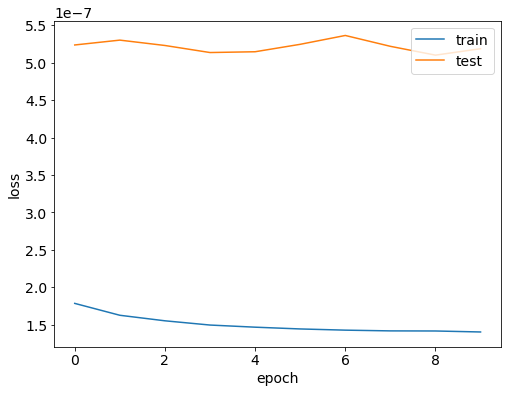

In [228]:
plot_result(history, encoder)

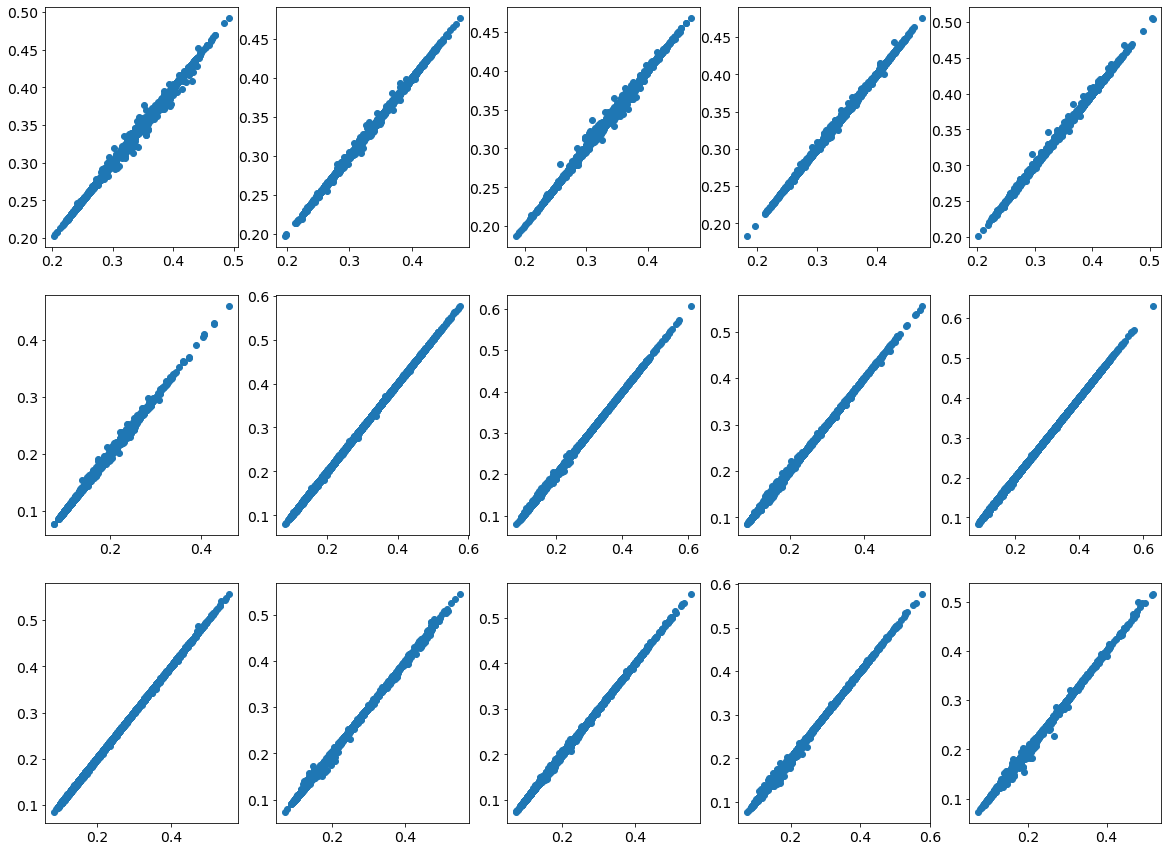

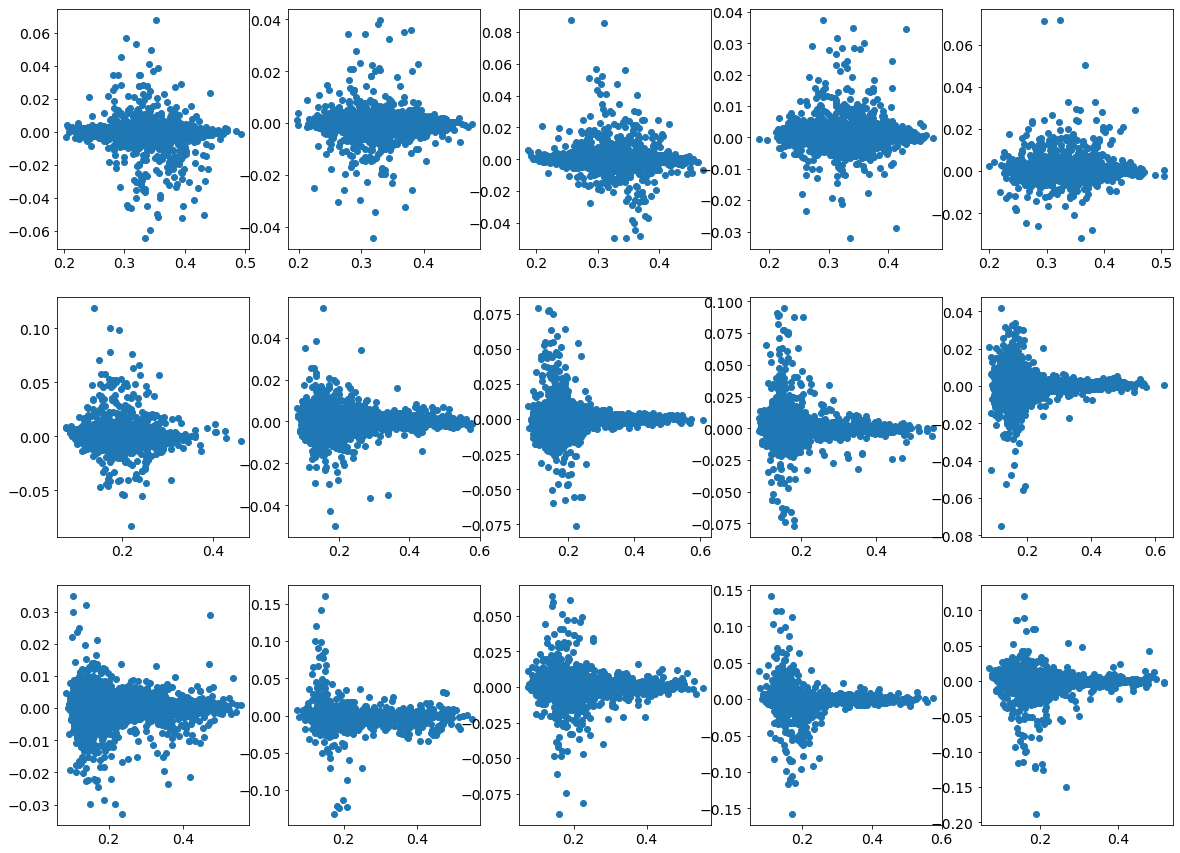

In [229]:
def plot_dis_vec(x1, x2):
    fig = plt.figure(figsize=(20,15))
    plots = []
    for i in range(15):
        plots.append(fig.add_subplot(3,5,i+1))
        plots[i].scatter(x1[:,i], x2[:,i])
    plt.show()
    
plot_dis_vec(val_x, encoder.predict(val_x))
plot_dis_vec(val_x, (encoder.predict(val_x)-val_x)/val_x)

In [102]:
#encoder.save_weights('dense_encoder_weights.h5')

In [103]:
encoder.trainable = False
encoder.pop()
encoder.pop()
encoder.pop()
encoder.pop()
encoder.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_222 (Dense)            (None, 256)               4096      
_________________________________________________________________
dense_223 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_224 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_225 (Dense)            (None, 12)                3084      
Total params: 138,764
Trainable params: 0
Non-trainable params: 138,764
_________________________________________________________________


In [37]:
inputs = tf.keras.Input(shape=(15,))
vectorize = encoder(inputs, training=False)

d1 = layers.Dense(512, activation=tf.nn.swish)(vectorize)
d2 = layers.Dense(512, activation=tf.nn.swish)(d1)
d3 = layers.Dense(512, activation=tf.nn.swish)(d2)
d4 = layers.Dense(512, activation=tf.nn.swish)(d3)
output = layers.Dense(1, activation=tf.nn.swish)(d4)

PES = tf.keras.Model(inputs, output)
PES.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 15)                2441      
_________________________________________________________________
dense_66 (Dense)             (None, 512)               8192      
_________________________________________________________________
dense_67 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_68 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_69 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 513   

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

PES.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])

train_y_scaled = train_y / 10000

In [128]:
history = PES.fit(train_x, train_y_scaled, validation_split=0.1, batch_size=64, epochs=1000)

Epoch 1/1000
972/972 [==============================] - 5s 5ms/step - loss: 8.9275e-04 - val_loss: 0.0040
Epoch 2/1000
972/972 [==============================] - 5s 5ms/step - loss: 9.0992e-04 - val_loss: 0.0043
Epoch 3/1000
972/972 [==============================] - 5s 5ms/step - loss: 8.6401e-04 - val_loss: 0.0046
Epoch 4/1000
972/972 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 5/1000
972/972 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 6/1000
972/972 [==============================] - 5s 5ms/step - loss: 8.0904e-04 - val_loss: 0.0037
Epoch 7/1000
972/972 [==============================] - 4s 5ms/step - loss: 9.0992e-04 - val_loss: 0.0039
Epoch 8/1000
972/972 [==============================] - 3s 3ms/step - loss: 9.4492e-04 - val_loss: 0.0042
Epoch 9/1000
972/972 [==============================] - 4s 4ms/step - loss: 8.9784e-04 - val_loss: 0.0043
Epoch 10/1000
972/972 [==============================]

Epoch 78/1000
972/972 [==============================] - 3s 3ms/step - loss: 8.1241e-04 - val_loss: 0.0042
Epoch 79/1000
972/972 [==============================] - 3s 3ms/step - loss: 8.0968e-04 - val_loss: 0.0038
Epoch 80/1000
972/972 [==============================] - 4s 5ms/step - loss: 9.3238e-04 - val_loss: 0.0040
Epoch 81/1000
972/972 [==============================] - 3s 3ms/step - loss: 8.6105e-04 - val_loss: 0.0039
Epoch 82/1000
972/972 [==============================] - 3s 4ms/step - loss: 8.4596e-04 - val_loss: 0.0042
Epoch 83/1000
972/972 [==============================] - 4s 4ms/step - loss: 8.3528e-04 - val_loss: 0.0040
Epoch 84/1000
972/972 [==============================] - 4s 4ms/step - loss: 8.7402e-04 - val_loss: 0.0043
Epoch 85/1000
972/972 [==============================] - 4s 4ms/step - loss: 9.4382e-04 - val_loss: 0.0042
Epoch 86/1000
972/972 [==============================] - 4s 5ms/step - loss: 7.7455e-04 - val_loss: 0.0038
Epoch 87/1000
972/972 [==============

972/972 [==============================] - 5s 5ms/step - loss: 7.7297e-04 - val_loss: 0.0046
Epoch 155/1000
972/972 [==============================] - 5s 5ms/step - loss: 8.1765e-04 - val_loss: 0.0039
Epoch 156/1000
972/972 [==============================] - 5s 5ms/step - loss: 7.6092e-04 - val_loss: 0.0039
Epoch 157/1000
972/972 [==============================] - 5s 5ms/step - loss: 8.9809e-04 - val_loss: 0.0040
Epoch 158/1000
972/972 [==============================] - 3s 3ms/step - loss: 8.4425e-04 - val_loss: 0.0039
Epoch 159/1000
972/972 [==============================] - 4s 4ms/step - loss: 7.6144e-04 - val_loss: 0.0043
Epoch 160/1000
972/972 [==============================] - 3s 3ms/step - loss: 8.0663e-04 - val_loss: 0.0042
Epoch 161/1000
972/972 [==============================] - 4s 4ms/step - loss: 8.1259e-04 - val_loss: 0.0039
Epoch 162/1000
972/972 [==============================] - 5s 5ms/step - loss: 7.8543e-04 - val_loss: 0.0042
Epoch 163/1000
972/972 [===================

Epoch 230/1000
972/972 [==============================] - 3s 3ms/step - loss: 8.2835e-04 - val_loss: 0.0037
Epoch 231/1000
972/972 [==============================] - 4s 4ms/step - loss: 6.8544e-04 - val_loss: 0.0041
Epoch 232/1000
972/972 [==============================] - 4s 4ms/step - loss: 7.6446e-04 - val_loss: 0.0039
Epoch 233/1000
972/972 [==============================] - 4s 4ms/step - loss: 8.4373e-04 - val_loss: 0.0039
Epoch 234/1000
972/972 [==============================] - 3s 4ms/step - loss: 7.3776e-04 - val_loss: 0.0039
Epoch 235/1000
972/972 [==============================] - 4s 4ms/step - loss: 7.2437e-04 - val_loss: 0.0041
Epoch 236/1000
972/972 [==============================] - 4s 4ms/step - loss: 7.4683e-04 - val_loss: 0.0038
Epoch 237/1000
972/972 [==============================] - 3s 3ms/step - loss: 8.3459e-04 - val_loss: 0.0039
Epoch 238/1000
972/972 [==============================] - 4s 4ms/step - loss: 7.4808e-04 - val_loss: 0.0040
Epoch 239/1000
772/972 [====

KeyboardInterrupt: 

In [196]:
plot_result(history, PES)

53748.71754741928

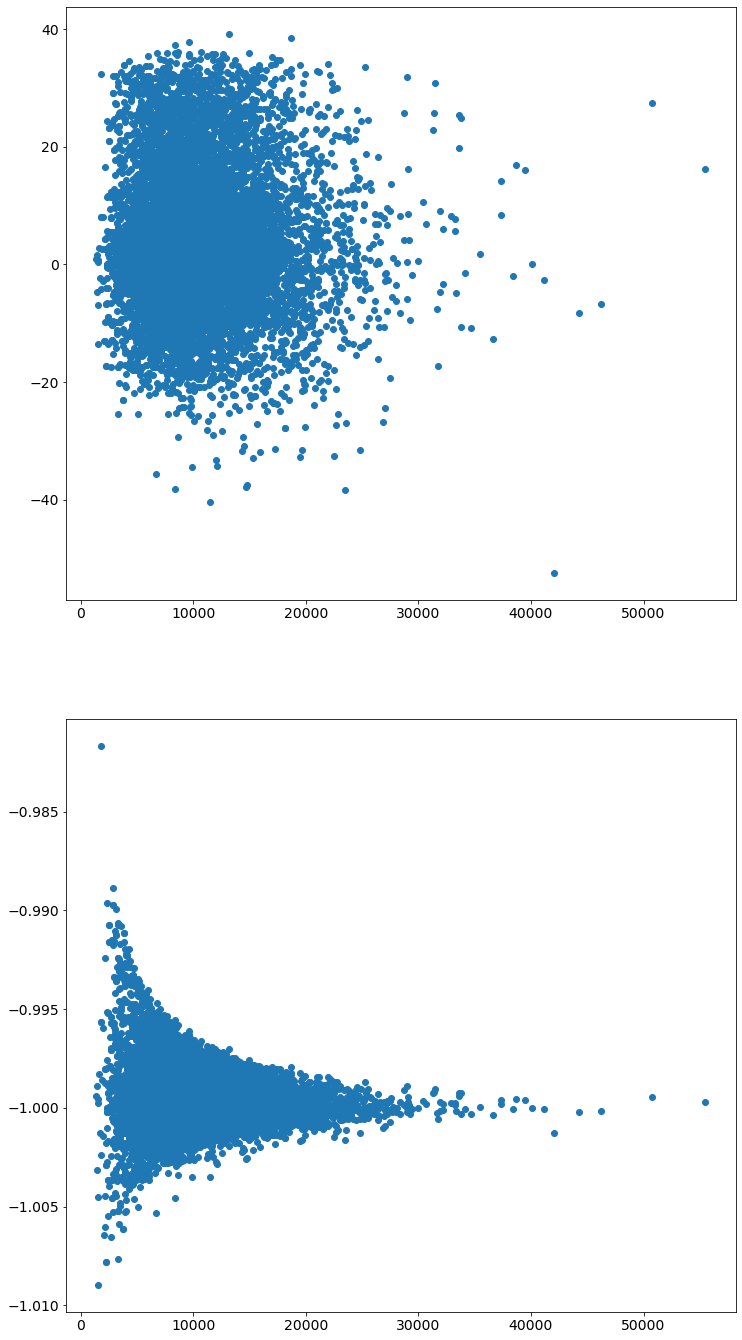

In [236]:
def plot_dis_vec(x1, x2):
    fig = plt.figure(figsize=(12,24))

    loss = fig.add_subplot(2,1,1)
    loss.scatter(x1, x2)
    
    percent_loss = fig.add_subplot(2,1,2)
    percent_loss.scatter(x1, (x2-x1)/x1)
    
    plt.show()
    
plot_dis_vec(val_y[:,np.newaxis], PES.predict(val_x)*10000)

In [124]:
PES.predict(val_x)*10000

array([[20780.01  ],
       [12930.268 ],
       [13442.302 ],
       ...,
       [ 5188.1304],
       [ 2737.3245],
       [ 5347.6523]], dtype=float32)

In [125]:
val_y

array([22621.20096108, 12600.49808717, 13274.706392  , ...,
        5279.78782319,  2675.08994819,  5483.53165644])

In [239]:
raw = models.Sequential()
raw.add(layers.Dense(64, activation=tf.nn.swish, input_shape=(15,)))
raw.add(layers.Dense(64, activation=tf.nn.swish))
raw.add(layers.Dense(64, activation=tf.nn.swish))
raw.add(layers.Dense(64, activation=tf.nn.swish))
raw.add(layers.Dense(64, activation=tf.nn.swish))
raw.add(layers.Dense(1, activation='linear'))

raw.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_227 (Dense)            (None, 64)                1024      
_________________________________________________________________
dense_228 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_229 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_230 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_231 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_232 (Dense)            (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________

In [240]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

raw.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])


In [ ]:
history = raw.fit(train_x, train_y_scaled, validation_split=0.1, batch_size=512, epochs=5000)

Epoch 1/5000
122/122 [==============================] - 0s 4ms/step - loss: 4.0187e-04 - val_loss: 4.7841e-04
Epoch 2/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.7006e-04 - val_loss: 4.6289e-04
Epoch 3/5000
122/122 [==============================] - 0s 4ms/step - loss: 4.6723e-04 - val_loss: 4.8354e-04
Epoch 4/5000
122/122 [==============================] - 0s 3ms/step - loss: 4.0474e-04 - val_loss: 3.6630e-04
Epoch 5/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.9840e-04 - val_loss: 4.3329e-04
Epoch 6/5000
122/122 [==============================] - 0s 2ms/step - loss: 4.6032e-04 - val_loss: 4.0255e-04
Epoch 7/5000
122/122 [==============================] - 0s 4ms/step - loss: 4.3482e-04 - val_loss: 4.7027e-04
Epoch 8/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.7081e-04 - val_loss: 4.9645e-04
Epoch 9/5000
122/122 [==============================] - 0s 3ms/step - loss: 4.0256e-04 - val_loss: 4.5013e-04
Epoch 10/5

Epoch 75/5000
122/122 [==============================] - 0s 2ms/step - loss: 3.9609e-04 - val_loss: 4.3235e-04
Epoch 76/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.7136e-04 - val_loss: 4.2969e-04
Epoch 77/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.7223e-04 - val_loss: 3.8559e-04
Epoch 78/5000
122/122 [==============================] - 0s 3ms/step - loss: 4.1848e-04 - val_loss: 3.5889e-04
Epoch 79/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.9807e-04 - val_loss: 7.2337e-04
Epoch 80/5000
122/122 [==============================] - 0s 4ms/step - loss: 4.0543e-04 - val_loss: 5.8533e-04
Epoch 81/5000
122/122 [==============================] - 0s 3ms/step - loss: 4.1858e-04 - val_loss: 5.0235e-04
Epoch 82/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.8758e-04 - val_loss: 4.5287e-04
Epoch 83/5000
122/122 [==============================] - 0s 2ms/step - loss: 3.7251e-04 - val_loss: 7.0514e-04
E

122/122 [==============================] - 0s 3ms/step - loss: 5.3252e-04 - val_loss: 3.4033e-04
Epoch 149/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.5156e-04 - val_loss: 3.5557e-04
Epoch 150/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.4683e-04 - val_loss: 3.2261e-04
Epoch 151/5000
122/122 [==============================] - 1s 5ms/step - loss: 3.5374e-04 - val_loss: 4.2842e-04
Epoch 152/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.7184e-04 - val_loss: 6.0070e-04
Epoch 153/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.9667e-04 - val_loss: 4.2346e-04
Epoch 154/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.7917e-04 - val_loss: 6.4334e-04
Epoch 155/5000
122/122 [==============================] - 0s 3ms/step - loss: 4.2365e-04 - val_loss: 4.7602e-04
Epoch 156/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.7675e-04 - val_loss: 4.8182e-04
Epoch 1

122/122 [==============================] - 0s 2ms/step - loss: 3.6837e-04 - val_loss: 8.0253e-04
Epoch 222/5000
122/122 [==============================] - 1s 5ms/step - loss: 4.0117e-04 - val_loss: 5.6674e-04
Epoch 223/5000
122/122 [==============================] - 0s 2ms/step - loss: 3.5876e-04 - val_loss: 4.4574e-04
Epoch 224/5000
122/122 [==============================] - 0s 2ms/step - loss: 3.3633e-04 - val_loss: 3.6584e-04
Epoch 225/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.3852e-04 - val_loss: 4.3517e-04
Epoch 226/5000
122/122 [==============================] - 0s 2ms/step - loss: 3.7811e-04 - val_loss: 3.9024e-04
Epoch 227/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.6295e-04 - val_loss: 3.3100e-04
Epoch 228/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.3622e-04 - val_loss: 4.1026e-04
Epoch 229/5000
122/122 [==============================] - 0s 3ms/step - loss: 4.0080e-04 - val_loss: 3.9964e-04
Epoch 2

122/122 [==============================] - 0s 3ms/step - loss: 3.3790e-04 - val_loss: 3.6837e-04
Epoch 295/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.5375e-04 - val_loss: 4.6697e-04
Epoch 296/5000
122/122 [==============================] - 1s 5ms/step - loss: 4.0584e-04 - val_loss: 5.1557e-04
Epoch 297/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.2103e-04 - val_loss: 3.7871e-04
Epoch 298/5000
122/122 [==============================] - 1s 5ms/step - loss: 3.4842e-04 - val_loss: 4.6156e-04
Epoch 299/5000
122/122 [==============================] - 1s 5ms/step - loss: 3.2021e-04 - val_loss: 4.4689e-04
Epoch 300/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.6672e-04 - val_loss: 5.6176e-04
Epoch 301/5000
122/122 [==============================] - 0s 3ms/step - loss: 4.2953e-04 - val_loss: 3.9618e-04
Epoch 302/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.0383e-04 - val_loss: 4.0792e-04
Epoch 3

122/122 [==============================] - 1s 4ms/step - loss: 3.2752e-04 - val_loss: 5.4180e-04
Epoch 368/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.5301e-04 - val_loss: 3.7646e-04
Epoch 369/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.4972e-04 - val_loss: 3.7957e-04
Epoch 370/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.2270e-04 - val_loss: 7.2938e-04
Epoch 371/5000
122/122 [==============================] - 1s 4ms/step - loss: 4.1876e-04 - val_loss: 4.0901e-04
Epoch 372/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.0063e-04 - val_loss: 3.8898e-04
Epoch 373/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.1842e-04 - val_loss: 4.5311e-04
Epoch 374/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.5041e-04 - val_loss: 4.6188e-04
Epoch 375/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.3654e-04 - val_loss: 4.6777e-04
Epoch 3

122/122 [==============================] - 0s 3ms/step - loss: 3.2811e-04 - val_loss: 4.4361e-04
Epoch 441/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.1425e-04 - val_loss: 3.3700e-04
Epoch 442/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.2078e-04 - val_loss: 3.8090e-04
Epoch 443/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.6722e-04 - val_loss: 3.6925e-04
Epoch 444/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.2544e-04 - val_loss: 3.1515e-04
Epoch 445/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.5916e-04 - val_loss: 5.1918e-04
Epoch 446/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.6735e-04 - val_loss: 3.5779e-04
Epoch 447/5000
122/122 [==============================] - 0s 2ms/step - loss: 3.2874e-04 - val_loss: 3.3188e-04
Epoch 448/5000
122/122 [==============================] - 0s 2ms/step - loss: 3.1446e-04 - val_loss: 3.7957e-04
Epoch 4

122/122 [==============================] - 0s 3ms/step - loss: 3.1598e-04 - val_loss: 3.9681e-04
Epoch 514/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.8237e-04 - val_loss: 3.9447e-04
Epoch 515/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.2360e-04 - val_loss: 4.1514e-04
Epoch 516/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.5295e-04 - val_loss: 3.1378e-04
Epoch 517/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.3499e-04 - val_loss: 2.6624e-04
Epoch 518/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.3156e-04 - val_loss: 9.1266e-04
Epoch 519/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.6554e-04 - val_loss: 3.8199e-04
Epoch 520/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.8669e-04 - val_loss: 4.7386e-04
Epoch 521/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.9169e-04 - val_loss: 3.6119e-04
Epoch 5

122/122 [==============================] - 0s 3ms/step - loss: 3.3080e-04 - val_loss: 3.6133e-04
Epoch 587/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.6407e-04 - val_loss: 4.2227e-04
Epoch 588/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.9279e-04 - val_loss: 4.0327e-04
Epoch 589/5000
122/122 [==============================] - 1s 5ms/step - loss: 3.0671e-04 - val_loss: 3.8038e-04
Epoch 590/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.5157e-04 - val_loss: 4.4737e-04
Epoch 591/5000
122/122 [==============================] - 1s 5ms/step - loss: 3.6974e-04 - val_loss: 6.9271e-04
Epoch 592/5000
122/122 [==============================] - 0s 4ms/step - loss: 4.0670e-04 - val_loss: 3.8970e-04
Epoch 593/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.0492e-04 - val_loss: 3.3942e-04
Epoch 594/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7277e-04 - val_loss: 3.2011e-04
Epoch 5

122/122 [==============================] - 0s 4ms/step - loss: 3.2350e-04 - val_loss: 3.9496e-04
Epoch 660/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7306e-04 - val_loss: 3.5815e-04
Epoch 661/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.4507e-04 - val_loss: 4.0375e-04
Epoch 662/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.4899e-04 - val_loss: 8.6372e-04
Epoch 663/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.1199e-04 - val_loss: 3.0455e-04
Epoch 664/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4774e-04 - val_loss: 3.0970e-04
Epoch 665/5000
122/122 [==============================] - 1s 5ms/step - loss: 3.1637e-04 - val_loss: 4.1175e-04
Epoch 666/5000
122/122 [==============================] - 0s 4ms/step - loss: 4.1445e-04 - val_loss: 5.7542e-04
Epoch 667/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.8812e-04 - val_loss: 3.0022e-04
Epoch 6

122/122 [==============================] - 0s 4ms/step - loss: 2.5411e-04 - val_loss: 2.9028e-04
Epoch 733/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.4261e-04 - val_loss: 3.0256e-04
Epoch 734/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.8120e-04 - val_loss: 3.6566e-04
Epoch 735/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.1673e-04 - val_loss: 3.8009e-04
Epoch 736/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.9638e-04 - val_loss: 3.0290e-04
Epoch 737/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.6669e-04 - val_loss: 3.2491e-04
Epoch 738/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.4052e-04 - val_loss: 3.3572e-04
Epoch 739/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.2181e-04 - val_loss: 3.2495e-04
Epoch 740/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.3733e-04 - val_loss: 3.8715e-04
Epoch 7

122/122 [==============================] - 0s 3ms/step - loss: 3.0097e-04 - val_loss: 3.1620e-04
Epoch 806/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.7192e-04 - val_loss: 3.5333e-04
Epoch 807/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.6529e-04 - val_loss: 3.5103e-04
Epoch 808/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.7856e-04 - val_loss: 5.4947e-04
Epoch 809/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.1200e-04 - val_loss: 4.5047e-04
Epoch 810/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.0788e-04 - val_loss: 3.3062e-04
Epoch 811/5000
122/122 [==============================] - 0s 3ms/step - loss: 3.0722e-04 - val_loss: 3.6346e-04
Epoch 812/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7969e-04 - val_loss: 3.1322e-04
Epoch 813/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.7115e-04 - val_loss: 4.4812e-04
Epoch 8

122/122 [==============================] - 0s 3ms/step - loss: 3.0202e-04 - val_loss: 3.3013e-04
Epoch 879/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.0055e-04 - val_loss: 2.9737e-04
Epoch 880/5000
122/122 [==============================] - 1s 6ms/step - loss: 2.5165e-04 - val_loss: 4.0946e-04
Epoch 881/5000
122/122 [==============================] - 0s 2ms/step - loss: 2.9893e-04 - val_loss: 3.2056e-04
Epoch 882/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.7580e-04 - val_loss: 3.4482e-04
Epoch 883/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.8030e-04 - val_loss: 3.1340e-04
Epoch 884/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.6459e-04 - val_loss: 3.5018e-04
Epoch 885/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.8216e-04 - val_loss: 4.0758e-04
Epoch 886/5000
122/122 [==============================] - 1s 6ms/step - loss: 3.0716e-04 - val_loss: 3.0158e-04
Epoch 8

122/122 [==============================] - 0s 3ms/step - loss: 2.7557e-04 - val_loss: 3.9728e-04
Epoch 952/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.9707e-04 - val_loss: 2.7073e-04
Epoch 953/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.3767e-04 - val_loss: 3.1785e-04
Epoch 954/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.5494e-04 - val_loss: 3.1901e-04
Epoch 955/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7283e-04 - val_loss: 3.7099e-04
Epoch 956/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.7586e-04 - val_loss: 4.1138e-04
Epoch 957/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.0026e-04 - val_loss: 3.3624e-04
Epoch 958/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.8567e-04 - val_loss: 5.0975e-04
Epoch 959/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.9576e-04 - val_loss: 3.2087e-04
Epoch 9

122/122 [==============================] - 0s 4ms/step - loss: 2.3774e-04 - val_loss: 3.3407e-04
Epoch 1025/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4990e-04 - val_loss: 3.2329e-04
Epoch 1026/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.8917e-04 - val_loss: 4.1122e-04
Epoch 1027/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.9860e-04 - val_loss: 3.4234e-04
Epoch 1028/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7323e-04 - val_loss: 3.3887e-04
Epoch 1029/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.6698e-04 - val_loss: 2.7533e-04
Epoch 1030/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5631e-04 - val_loss: 2.7335e-04
Epoch 1031/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5718e-04 - val_loss: 5.9699e-04
Epoch 1032/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4832e-04 - val_loss: 3.0683e-04

122/122 [==============================] - 0s 4ms/step - loss: 2.4497e-04 - val_loss: 3.1988e-04
Epoch 1097/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.1081e-04 - val_loss: 2.5985e-04
Epoch 1098/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.7976e-04 - val_loss: 3.4185e-04
Epoch 1099/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.9554e-04 - val_loss: 2.8584e-04
Epoch 1100/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.3562e-04 - val_loss: 3.7899e-04
Epoch 1101/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.6309e-04 - val_loss: 3.8967e-04
Epoch 1102/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5640e-04 - val_loss: 3.2500e-04
Epoch 1103/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.5160e-04 - val_loss: 4.1462e-04
Epoch 1104/5000
122/122 [==============================] - 0s 4ms/step - loss: 3.1057e-04 - val_loss: 4.4183e-04

122/122 [==============================] - 1s 4ms/step - loss: 2.6810e-04 - val_loss: 3.5629e-04
Epoch 1169/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5640e-04 - val_loss: 3.6456e-04
Epoch 1170/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.4505e-04 - val_loss: 3.4228e-04
Epoch 1171/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5248e-04 - val_loss: 3.1314e-04
Epoch 1172/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.4025e-04 - val_loss: 2.6246e-04
Epoch 1173/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.4938e-04 - val_loss: 2.6870e-04
Epoch 1174/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.9593e-04 - val_loss: 2.8378e-04
Epoch 1175/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4889e-04 - val_loss: 3.3564e-04
Epoch 1176/5000
122/122 [==============================] - 0s 2ms/step - loss: 2.9244e-04 - val_loss: 4.5194e-04

122/122 [==============================] - 1s 4ms/step - loss: 2.5942e-04 - val_loss: 3.2698e-04
Epoch 1241/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.3630e-04 - val_loss: 2.8012e-04
Epoch 1242/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.2694e-04 - val_loss: 3.3527e-04
Epoch 1243/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.5614e-04 - val_loss: 3.9755e-04
Epoch 1244/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5974e-04 - val_loss: 3.7567e-04
Epoch 1245/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2687e-04 - val_loss: 3.4007e-04
Epoch 1246/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.5708e-04 - val_loss: 4.5316e-04
Epoch 1247/5000
122/122 [==============================] - 1s 6ms/step - loss: 2.8389e-04 - val_loss: 3.1162e-04
Epoch 1248/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7064e-04 - val_loss: 3.4696e-04

122/122 [==============================] - 0s 3ms/step - loss: 2.8816e-04 - val_loss: 2.5644e-04
Epoch 1313/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2222e-04 - val_loss: 3.9654e-04
Epoch 1314/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.7876e-04 - val_loss: 3.6621e-04
Epoch 1315/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.3847e-04 - val_loss: 3.8517e-04
Epoch 1316/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4919e-04 - val_loss: 2.3617e-04
Epoch 1317/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.3595e-04 - val_loss: 3.5641e-04
Epoch 1318/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5227e-04 - val_loss: 2.7353e-04
Epoch 1319/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.3011e-04 - val_loss: 2.7660e-04
Epoch 1320/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.3936e-04 - val_loss: 3.6318e-04

122/122 [==============================] - 1s 5ms/step - loss: 2.5595e-04 - val_loss: 4.8485e-04
Epoch 1385/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0542e-04 - val_loss: 3.3787e-04
Epoch 1386/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.1118e-04 - val_loss: 2.8108e-04
Epoch 1387/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.4280e-04 - val_loss: 3.9941e-04
Epoch 1388/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.9678e-04 - val_loss: 4.1723e-04
Epoch 1389/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.6450e-04 - val_loss: 2.7182e-04
Epoch 1390/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.1513e-04 - val_loss: 2.7743e-04
Epoch 1391/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.3559e-04 - val_loss: 3.3887e-04
Epoch 1392/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.4679e-04 - val_loss: 3.8869e-04

122/122 [==============================] - 0s 4ms/step - loss: 2.9087e-04 - val_loss: 4.2813e-04
Epoch 1457/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.5960e-04 - val_loss: 2.7772e-04
Epoch 1458/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2434e-04 - val_loss: 3.0142e-04
Epoch 1459/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2323e-04 - val_loss: 2.4742e-04
Epoch 1460/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.7855e-04 - val_loss: 3.6057e-04
Epoch 1461/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4795e-04 - val_loss: 2.2986e-04
Epoch 1462/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.3781e-04 - val_loss: 2.7380e-04
Epoch 1463/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.3331e-04 - val_loss: 2.8867e-04
Epoch 1464/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.3660e-04 - val_loss: 3.0041e-04

122/122 [==============================] - 0s 4ms/step - loss: 2.2263e-04 - val_loss: 4.4945e-04
Epoch 1529/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4305e-04 - val_loss: 2.5384e-04
Epoch 1530/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4133e-04 - val_loss: 2.9838e-04
Epoch 1531/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4409e-04 - val_loss: 4.1143e-04
Epoch 1532/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.0014e-04 - val_loss: 3.4494e-04
Epoch 1533/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.1753e-04 - val_loss: 4.4632e-04
Epoch 1534/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.7573e-04 - val_loss: 3.2586e-04
Epoch 1535/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4911e-04 - val_loss: 3.5204e-04
Epoch 1536/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7921e-04 - val_loss: 4.9634e-04

122/122 [==============================] - 1s 5ms/step - loss: 1.9418e-04 - val_loss: 2.6382e-04
Epoch 1601/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.4194e-04 - val_loss: 3.2717e-04
Epoch 1602/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.7109e-04 - val_loss: 5.6553e-04
Epoch 1603/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7033e-04 - val_loss: 3.4134e-04
Epoch 1604/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.1474e-04 - val_loss: 3.0714e-04
Epoch 1605/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5440e-04 - val_loss: 2.7508e-04
Epoch 1606/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5505e-04 - val_loss: 4.8079e-04
Epoch 1607/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.3757e-04 - val_loss: 2.5736e-04
Epoch 1608/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2035e-04 - val_loss: 3.4305e-04

122/122 [==============================] - 0s 3ms/step - loss: 2.3470e-04 - val_loss: 2.4630e-04
Epoch 1673/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.1246e-04 - val_loss: 2.9717e-04
Epoch 1674/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.2620e-04 - val_loss: 2.4005e-04
Epoch 1675/5000
122/122 [==============================] - 0s 2ms/step - loss: 2.1934e-04 - val_loss: 3.6663e-04
Epoch 1676/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.4099e-04 - val_loss: 3.1150e-04
Epoch 1677/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2042e-04 - val_loss: 3.3003e-04
Epoch 1678/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.3358e-04 - val_loss: 3.3171e-04
Epoch 1679/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2694e-04 - val_loss: 2.7593e-04
Epoch 1680/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.0730e-04 - val_loss: 2.4341e-04

122/122 [==============================] - 1s 5ms/step - loss: 2.0528e-04 - val_loss: 3.2474e-04
Epoch 1745/5000
122/122 [==============================] - 0s 2ms/step - loss: 2.4429e-04 - val_loss: 2.4370e-04
Epoch 1746/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0724e-04 - val_loss: 3.3841e-04
Epoch 1747/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.4658e-04 - val_loss: 2.3836e-04
Epoch 1748/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2979e-04 - val_loss: 2.8826e-04
Epoch 1749/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.4872e-04 - val_loss: 3.3683e-04
Epoch 1750/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0109e-04 - val_loss: 3.0903e-04
Epoch 1751/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.3171e-04 - val_loss: 2.7931e-04
Epoch 1752/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.3389e-04 - val_loss: 3.1686e-04

122/122 [==============================] - 1s 4ms/step - loss: 1.9689e-04 - val_loss: 3.4431e-04
Epoch 1817/5000
122/122 [==============================] - 0s 2ms/step - loss: 2.0038e-04 - val_loss: 4.3231e-04
Epoch 1818/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.0321e-04 - val_loss: 3.2270e-04
Epoch 1819/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.7522e-04 - val_loss: 2.7788e-04
Epoch 1820/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.3457e-04 - val_loss: 5.0145e-04
Epoch 1821/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.1395e-04 - val_loss: 3.3656e-04
Epoch 1822/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.1202e-04 - val_loss: 2.6221e-04
Epoch 1823/5000
122/122 [==============================] - 0s 2ms/step - loss: 2.3267e-04 - val_loss: 2.3148e-04
Epoch 1824/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0944e-04 - val_loss: 2.7599e-04

122/122 [==============================] - 0s 4ms/step - loss: 2.5197e-04 - val_loss: 2.3436e-04
Epoch 1889/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8749e-04 - val_loss: 2.6155e-04
Epoch 1890/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.9035e-04 - val_loss: 2.6202e-04
Epoch 1891/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.1937e-04 - val_loss: 3.0084e-04
Epoch 1892/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.3255e-04 - val_loss: 2.3620e-04
Epoch 1893/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.4887e-04 - val_loss: 3.2220e-04
Epoch 1894/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.5426e-04 - val_loss: 3.5942e-04
Epoch 1895/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2844e-04 - val_loss: 3.6024e-04
Epoch 1896/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.0711e-04 - val_loss: 2.5194e-04

122/122 [==============================] - 0s 3ms/step - loss: 2.0356e-04 - val_loss: 2.2938e-04
Epoch 1961/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.0763e-04 - val_loss: 3.1791e-04
Epoch 1962/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.0683e-04 - val_loss: 2.7167e-04
Epoch 1963/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.1972e-04 - val_loss: 3.5017e-04
Epoch 1964/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7903e-04 - val_loss: 2.2700e-04
Epoch 1965/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.9318e-04 - val_loss: 3.0251e-04
Epoch 1966/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.7183e-04 - val_loss: 3.4721e-04
Epoch 1967/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.1287e-04 - val_loss: 2.7138e-04
Epoch 1968/5000
122/122 [==============================] - 1s 4ms/step - loss: 3.1504e-04 - val_loss: 3.5607e-04

122/122 [==============================] - 0s 2ms/step - loss: 1.9118e-04 - val_loss: 3.5245e-04
Epoch 2033/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0565e-04 - val_loss: 2.6300e-04
Epoch 2034/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.9899e-04 - val_loss: 2.4764e-04
Epoch 2035/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.1025e-04 - val_loss: 3.4976e-04
Epoch 2036/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.3548e-04 - val_loss: 3.4198e-04
Epoch 2037/5000
122/122 [==============================] - 0s 1ms/step - loss: 2.0874e-04 - val_loss: 2.3880e-04
Epoch 2038/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.2017e-04 - val_loss: 3.4430e-04
Epoch 2039/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2738e-04 - val_loss: 2.4479e-04
Epoch 2040/5000
122/122 [==============================] - 0s 2ms/step - loss: 2.2737e-04 - val_loss: 2.4955e-04

122/122 [==============================] - 1s 4ms/step - loss: 2.2347e-04 - val_loss: 2.0998e-04
Epoch 2105/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.0395e-04 - val_loss: 2.7135e-04
Epoch 2106/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.5159e-04 - val_loss: 3.1359e-04
Epoch 2107/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2245e-04 - val_loss: 3.1639e-04
Epoch 2108/5000
122/122 [==============================] - 1s 6ms/step - loss: 2.0774e-04 - val_loss: 2.3432e-04
Epoch 2109/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.9243e-04 - val_loss: 2.4084e-04
Epoch 2110/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2723e-04 - val_loss: 3.0768e-04
Epoch 2111/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.4455e-04 - val_loss: 2.3636e-04
Epoch 2112/5000
122/122 [==============================] - 1s 6ms/step - loss: 1.9416e-04 - val_loss: 3.6526e-04

122/122 [==============================] - 0s 4ms/step - loss: 1.8848e-04 - val_loss: 4.5768e-04
Epoch 2177/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.7748e-04 - val_loss: 2.5602e-04
Epoch 2178/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.9442e-04 - val_loss: 2.4665e-04
Epoch 2179/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2092e-04 - val_loss: 3.4245e-04
Epoch 2180/5000
122/122 [==============================] - 0s 2ms/step - loss: 2.2841e-04 - val_loss: 2.8644e-04
Epoch 2181/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2338e-04 - val_loss: 2.8745e-04
Epoch 2182/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0441e-04 - val_loss: 2.9553e-04
Epoch 2183/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.9992e-04 - val_loss: 3.2119e-04
Epoch 2184/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.3130e-04 - val_loss: 2.5216e-04

122/122 [==============================] - 0s 3ms/step - loss: 2.0811e-04 - val_loss: 2.5595e-04
Epoch 2249/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.0348e-04 - val_loss: 2.5563e-04
Epoch 2250/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.9062e-04 - val_loss: 3.7165e-04
Epoch 2251/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.3039e-04 - val_loss: 3.1384e-04
Epoch 2252/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.9098e-04 - val_loss: 2.8346e-04
Epoch 2253/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.8246e-04 - val_loss: 2.5029e-04
Epoch 2254/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.0140e-04 - val_loss: 2.1270e-04
Epoch 2255/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0288e-04 - val_loss: 2.6067e-04
Epoch 2256/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.9516e-04 - val_loss: 3.0997e-04

122/122 [==============================] - 0s 2ms/step - loss: 1.8828e-04 - val_loss: 2.3387e-04
Epoch 2321/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.8607e-04 - val_loss: 2.2678e-04
Epoch 2322/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.9468e-04 - val_loss: 2.7445e-04
Epoch 2323/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.3376e-04 - val_loss: 2.3609e-04
Epoch 2324/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.9274e-04 - val_loss: 2.4173e-04
Epoch 2325/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.7805e-04 - val_loss: 2.9888e-04
Epoch 2326/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.6525e-04 - val_loss: 2.6453e-04
Epoch 2327/5000
122/122 [==============================] - 0s 1ms/step - loss: 2.1302e-04 - val_loss: 2.9705e-04
Epoch 2328/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.0199e-04 - val_loss: 2.9705e-04

122/122 [==============================] - 0s 3ms/step - loss: 2.0591e-04 - val_loss: 2.8004e-04
Epoch 2393/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.0880e-04 - val_loss: 3.8424e-04
Epoch 2394/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.8966e-04 - val_loss: 3.7691e-04
Epoch 2395/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.2617e-04 - val_loss: 3.1577e-04
Epoch 2396/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0894e-04 - val_loss: 2.2655e-04
Epoch 2397/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.9512e-04 - val_loss: 3.3528e-04
Epoch 2398/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.1112e-04 - val_loss: 2.5350e-04
Epoch 2399/5000
122/122 [==============================] - 1s 6ms/step - loss: 2.1897e-04 - val_loss: 3.8937e-04
Epoch 2400/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0687e-04 - val_loss: 2.3417e-04

122/122 [==============================] - 0s 4ms/step - loss: 1.8211e-04 - val_loss: 2.7462e-04
Epoch 2465/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.0890e-04 - val_loss: 2.8233e-04
Epoch 2466/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.0598e-04 - val_loss: 2.6984e-04
Epoch 2467/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.8100e-04 - val_loss: 3.1949e-04
Epoch 2468/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.3039e-04 - val_loss: 3.7200e-04
Epoch 2469/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.7821e-04 - val_loss: 2.5782e-04
Epoch 2470/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.4436e-04 - val_loss: 3.6456e-04
Epoch 2471/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.7462e-04 - val_loss: 2.2618e-04
Epoch 2472/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7263e-04 - val_loss: 2.2355e-04

122/122 [==============================] - 0s 3ms/step - loss: 1.7729e-04 - val_loss: 2.4686e-04
Epoch 2537/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.9639e-04 - val_loss: 3.3627e-04
Epoch 2538/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.1875e-04 - val_loss: 3.2746e-04
Epoch 2539/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.5875e-04 - val_loss: 2.6498e-04
Epoch 2540/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0368e-04 - val_loss: 2.6041e-04
Epoch 2541/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.7289e-04 - val_loss: 2.4641e-04
Epoch 2542/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.8413e-04 - val_loss: 3.0910e-04
Epoch 2543/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.1847e-04 - val_loss: 2.8890e-04
Epoch 2544/5000
122/122 [==============================] - 1s 6ms/step - loss: 1.7175e-04 - val_loss: 2.5801e-04

122/122 [==============================] - 1s 5ms/step - loss: 1.7531e-04 - val_loss: 2.4411e-04
Epoch 2609/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8640e-04 - val_loss: 2.2903e-04
Epoch 2610/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.9525e-04 - val_loss: 2.3816e-04
Epoch 2611/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.9977e-04 - val_loss: 2.2808e-04
Epoch 2612/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.7592e-04 - val_loss: 2.2923e-04
Epoch 2613/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.9423e-04 - val_loss: 2.7871e-04
Epoch 2614/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.9587e-04 - val_loss: 4.9039e-04
Epoch 2615/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2402e-04 - val_loss: 3.0681e-04
Epoch 2616/5000
122/122 [==============================] - 1s 6ms/step - loss: 2.0828e-04 - val_loss: 2.6107e-04

122/122 [==============================] - 0s 3ms/step - loss: 1.7813e-04 - val_loss: 2.1923e-04
Epoch 2681/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.1086e-04 - val_loss: 3.2934e-04
Epoch 2682/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7703e-04 - val_loss: 3.0573e-04
Epoch 2683/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.7682e-04 - val_loss: 3.3963e-04
Epoch 2684/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.9250e-04 - val_loss: 2.7005e-04
Epoch 2685/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.1449e-04 - val_loss: 2.0542e-04
Epoch 2686/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.6654e-04 - val_loss: 2.4753e-04
Epoch 2687/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.1194e-04 - val_loss: 2.3154e-04
Epoch 2688/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.9697e-04 - val_loss: 2.8013e-04

122/122 [==============================] - 0s 3ms/step - loss: 1.6456e-04 - val_loss: 2.0855e-04
Epoch 2753/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.5537e-04 - val_loss: 2.4666e-04
Epoch 2754/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.1428e-04 - val_loss: 2.5700e-04
Epoch 2755/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0301e-04 - val_loss: 2.3237e-04
Epoch 2756/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.9468e-04 - val_loss: 2.4222e-04
Epoch 2757/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.0777e-04 - val_loss: 2.0379e-04
Epoch 2758/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8557e-04 - val_loss: 2.2744e-04
Epoch 2759/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.5382e-04 - val_loss: 2.3787e-04
Epoch 2760/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.9667e-04 - val_loss: 2.5290e-04

122/122 [==============================] - 0s 3ms/step - loss: 1.6962e-04 - val_loss: 2.8855e-04
Epoch 2825/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.6409e-04 - val_loss: 2.3188e-04
Epoch 2826/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.9200e-04 - val_loss: 2.9617e-04
Epoch 2827/5000
122/122 [==============================] - 1s 4ms/step - loss: 2.1817e-04 - val_loss: 3.4497e-04
Epoch 2828/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.9239e-04 - val_loss: 2.3320e-04
Epoch 2829/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.6862e-04 - val_loss: 2.2681e-04
Epoch 2830/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.7733e-04 - val_loss: 3.4466e-04
Epoch 2831/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.8806e-04 - val_loss: 3.1967e-04
Epoch 2832/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8558e-04 - val_loss: 2.7147e-04

122/122 [==============================] - 0s 3ms/step - loss: 1.7964e-04 - val_loss: 2.5177e-04
Epoch 2897/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7440e-04 - val_loss: 2.2534e-04
Epoch 2898/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8833e-04 - val_loss: 2.0889e-04
Epoch 2899/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.8767e-04 - val_loss: 3.1699e-04
Epoch 2900/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8215e-04 - val_loss: 2.5844e-04
Epoch 2901/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.1667e-04 - val_loss: 2.4091e-04
Epoch 2902/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.1053e-04 - val_loss: 4.3531e-04
Epoch 2903/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2722e-04 - val_loss: 2.2803e-04
Epoch 2904/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.7251e-04 - val_loss: 2.9081e-04

122/122 [==============================] - 0s 3ms/step - loss: 1.7187e-04 - val_loss: 2.5888e-04
Epoch 2969/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.9282e-04 - val_loss: 3.1699e-04
Epoch 2970/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.7455e-04 - val_loss: 2.5135e-04
Epoch 2971/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.9145e-04 - val_loss: 4.1666e-04
Epoch 2972/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.1183e-04 - val_loss: 2.6201e-04
Epoch 2973/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.0787e-04 - val_loss: 2.3530e-04
Epoch 2974/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.7919e-04 - val_loss: 2.5519e-04
Epoch 2975/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.6719e-04 - val_loss: 2.5440e-04
Epoch 2976/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8364e-04 - val_loss: 2.5235e-04

122/122 [==============================] - 0s 4ms/step - loss: 2.3590e-04 - val_loss: 3.2723e-04
Epoch 3041/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.9204e-04 - val_loss: 2.2331e-04
Epoch 3042/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.4728e-04 - val_loss: 2.0465e-04
Epoch 3043/5000
122/122 [==============================] - 1s 6ms/step - loss: 1.3879e-04 - val_loss: 2.0611e-04
Epoch 3044/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.2146e-04 - val_loss: 2.7821e-04
Epoch 3045/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.8247e-04 - val_loss: 3.2767e-04
Epoch 3046/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.9551e-04 - val_loss: 2.4498e-04
Epoch 3047/5000
122/122 [==============================] - 1s 6ms/step - loss: 1.6073e-04 - val_loss: 2.3199e-04
Epoch 3048/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7278e-04 - val_loss: 3.6315e-04

122/122 [==============================] - 1s 4ms/step - loss: 1.7851e-04 - val_loss: 3.4066e-04
Epoch 3113/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.8974e-04 - val_loss: 2.4791e-04
Epoch 3114/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.4551e-04 - val_loss: 1.9635e-04
Epoch 3115/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.9117e-04 - val_loss: 2.8384e-04
Epoch 3116/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.7829e-04 - val_loss: 2.6124e-04
Epoch 3117/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7704e-04 - val_loss: 2.3945e-04
Epoch 3118/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8156e-04 - val_loss: 2.5488e-04
Epoch 3119/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.8558e-04 - val_loss: 3.4291e-04
Epoch 3120/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.7541e-04 - val_loss: 2.3748e-04

122/122 [==============================] - 1s 5ms/step - loss: 1.6719e-04 - val_loss: 2.1631e-04
Epoch 3185/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.6537e-04 - val_loss: 2.4464e-04
Epoch 3186/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.8287e-04 - val_loss: 2.3106e-04
Epoch 3187/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.6987e-04 - val_loss: 2.6345e-04
Epoch 3188/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.0963e-04 - val_loss: 2.4690e-04
Epoch 3189/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0917e-04 - val_loss: 2.4417e-04
Epoch 3190/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.6425e-04 - val_loss: 2.7078e-04
Epoch 3191/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.2064e-04 - val_loss: 2.6398e-04
Epoch 3192/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.5234e-04 - val_loss: 3.2876e-04

122/122 [==============================] - 0s 1ms/step - loss: 2.2657e-04 - val_loss: 2.9727e-04
Epoch 3257/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.8606e-04 - val_loss: 2.5894e-04
Epoch 3258/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.7813e-04 - val_loss: 2.9831e-04
Epoch 3259/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.5301e-04 - val_loss: 2.5239e-04
Epoch 3260/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.7530e-04 - val_loss: 1.9201e-04
Epoch 3261/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.6534e-04 - val_loss: 3.1418e-04
Epoch 3262/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.8815e-04 - val_loss: 2.8779e-04
Epoch 3263/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7021e-04 - val_loss: 2.6505e-04
Epoch 3264/5000
122/122 [==============================] - 0s 4ms/step - loss: 2.0733e-04 - val_loss: 2.9894e-04

122/122 [==============================] - 1s 5ms/step - loss: 1.7300e-04 - val_loss: 2.6639e-04
Epoch 3329/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.7251e-04 - val_loss: 3.7983e-04
Epoch 3330/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.7964e-04 - val_loss: 2.6154e-04
Epoch 3331/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8330e-04 - val_loss: 2.6950e-04
Epoch 3332/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.8499e-04 - val_loss: 2.9339e-04
Epoch 3333/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8984e-04 - val_loss: 2.3808e-04
Epoch 3334/5000
122/122 [==============================] - 1s 5ms/step - loss: 2.1227e-04 - val_loss: 2.6532e-04
Epoch 3335/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.7794e-04 - val_loss: 2.0040e-04
Epoch 3336/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.5856e-04 - val_loss: 1.9897e-04

122/122 [==============================] - 0s 3ms/step - loss: 1.7170e-04 - val_loss: 2.6539e-04
Epoch 3401/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7199e-04 - val_loss: 2.3241e-04
Epoch 3402/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.5929e-04 - val_loss: 2.4467e-04
Epoch 3403/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.8660e-04 - val_loss: 2.3660e-04
Epoch 3404/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.7477e-04 - val_loss: 2.5900e-04
Epoch 3405/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.7959e-04 - val_loss: 2.7918e-04
Epoch 3406/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.6748e-04 - val_loss: 2.1407e-04
Epoch 3407/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7990e-04 - val_loss: 1.8390e-04
Epoch 3408/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.7495e-04 - val_loss: 2.3582e-04

122/122 [==============================] - 0s 3ms/step - loss: 1.6421e-04 - val_loss: 2.2929e-04
Epoch 3473/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.7292e-04 - val_loss: 2.3928e-04
Epoch 3474/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.9059e-04 - val_loss: 2.6939e-04
Epoch 3475/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.6551e-04 - val_loss: 2.3988e-04
Epoch 3476/5000
122/122 [==============================] - 1s 5ms/step - loss: 1.6798e-04 - val_loss: 3.0343e-04
Epoch 3477/5000
122/122 [==============================] - 1s 4ms/step - loss: 1.9741e-04 - val_loss: 2.2923e-04
Epoch 3478/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.8955e-04 - val_loss: 2.2857e-04
Epoch 3479/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.7648e-04 - val_loss: 1.9952e-04
Epoch 3480/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.6954e-04 - val_loss: 2.8763e-04

122/122 [==============================] - 0s 1ms/step - loss: 1.9980e-04 - val_loss: 2.7608e-04
Epoch 3545/5000
122/122 [==============================] - 0s 1ms/step - loss: 2.0659e-04 - val_loss: 4.0990e-04
Epoch 3546/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.8590e-04 - val_loss: 2.0876e-04
Epoch 3547/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.6557e-04 - val_loss: 2.4103e-04
Epoch 3548/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.6522e-04 - val_loss: 2.5598e-04
Epoch 3549/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.7578e-04 - val_loss: 2.4045e-04
Epoch 3550/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.8536e-04 - val_loss: 2.9562e-04
Epoch 3551/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.6827e-04 - val_loss: 2.1608e-04
Epoch 3552/5000
122/122 [==============================] - 0s 1ms/step - loss: 2.0638e-04 - val_loss: 2.3978e-04

122/122 [==============================] - 0s 1ms/step - loss: 1.5746e-04 - val_loss: 2.1275e-04
Epoch 3617/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.5179e-04 - val_loss: 2.4130e-04
Epoch 3618/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.8641e-04 - val_loss: 2.7153e-04
Epoch 3619/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.5325e-04 - val_loss: 2.7363e-04
Epoch 3620/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.9929e-04 - val_loss: 2.6683e-04
Epoch 3621/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.8215e-04 - val_loss: 2.0599e-04
Epoch 3622/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.8725e-04 - val_loss: 2.5792e-04
Epoch 3623/5000
122/122 [==============================] - 0s 1ms/step - loss: 1.5571e-04 - val_loss: 2.2559e-04
Epoch 3624/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.4570e-04 - val_loss: 2.5659e-04

122/122 [==============================] - 0s 2ms/step - loss: 1.6189e-04 - val_loss: 2.5654e-04
Epoch 3689/5000
122/122 [==============================] - 0s 2ms/step - loss: 1.4495e-04 - val_loss: 2.2305e-04
Epoch 3690/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.5591e-04 - val_loss: 2.3577e-04
Epoch 3691/5000
122/122 [==============================] - 0s 3ms/step - loss: 2.0692e-04 - val_loss: 2.2302e-04
Epoch 3692/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.5957e-04 - val_loss: 2.1452e-04
Epoch 3693/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.6134e-04 - val_loss: 2.7873e-04
Epoch 3694/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.7897e-04 - val_loss: 2.8786e-04
Epoch 3695/5000
122/122 [==============================] - 0s 3ms/step - loss: 1.6707e-04 - val_loss: 2.2925e-04
Epoch 3696/5000
122/122 [==============================] - 0s 4ms/step - loss: 1.6259e-04 - val_loss: 1.9320e-04

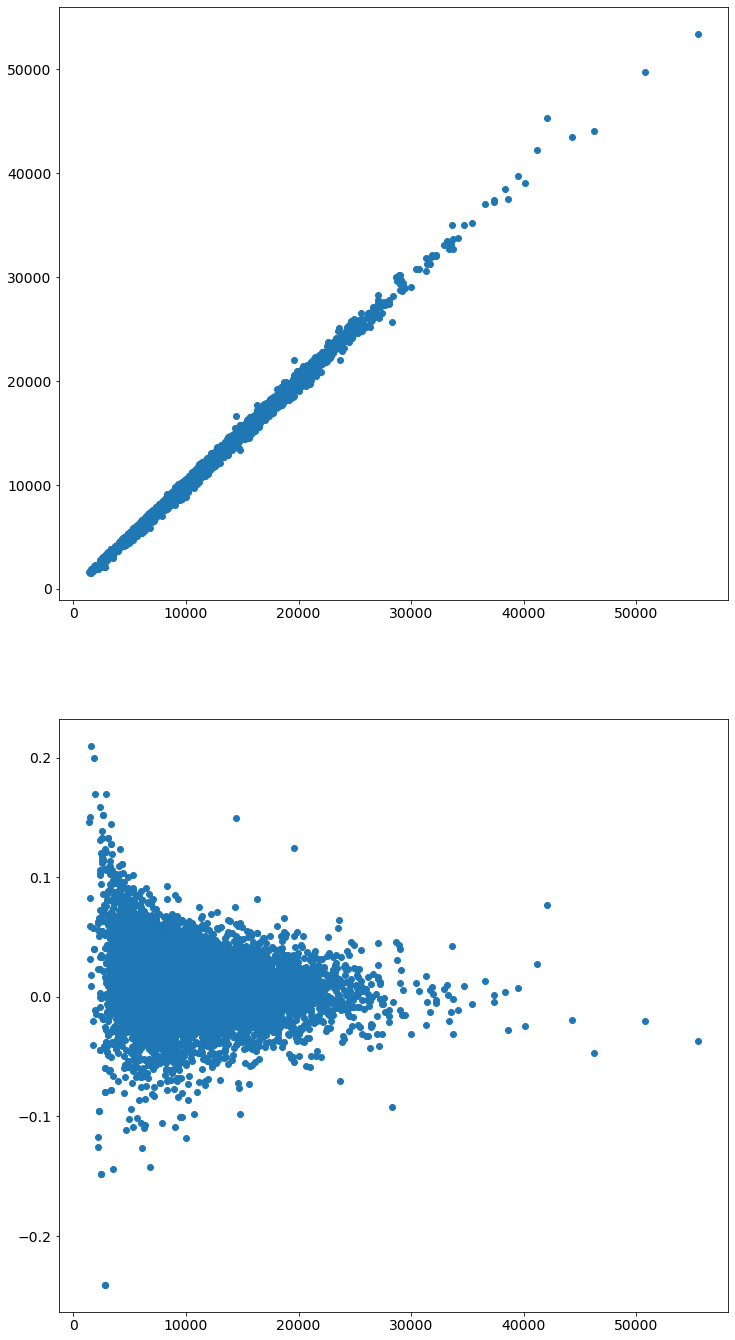

In [242]:
plot_dis_vec(val_y[:,np.newaxis], raw.predict(val_x)*10000)